# Airplane Paper Challenge

Problem proposed in 01_03_PhugoidFullModel notebook


## 1. Description of the Problem:

Suppose you wanted to participate in a paper-airplane competition, and you want to use what you know about the phugoid model to improve your chances. For a given value of $L/D$ that you can obtain in your design, you want to know what is the best initial velocity and launch angle to fly the longest distance from a given height.

Using the phugoid model, write a new code to analyze the flight of a paper airplane, with the following conditions:

*  Assume $L/D$ of 5.0 (a value close to measurements in Feng et al. 2009)
*  For the trim velocity, let's take an average value of 4.9 m/s.
*  Find a combination of launch angle and velocity that gives the best distance.
*  Think about how you will know when the flight needs to stop ... this will influence how you organize the code.
*  How can you check if your answer is realistic?

## 2. Approach and Strategy

Using previous developed code, we can simplify write the solution by defining two main functions. One `f` that would provide the right-hand side of the differential equation $f(\vec{u})$, and one that would execute a time-step using Euler's method, named `euler_step(u, f, dt)`.

The problem includes two new variables, the initial velocity $v_0$ and the initial pitch or angle of attack $\theta_0$. In the same way the $dt$ was a variable for the grid-convergence problem, we can use a defined set of values for $v_0$ and $\theta_0$, run our code for each one of them, and store the result in a recipient. 

Once completed, we can iterate through the elements of this recipient and find the largest value of $x$, $x_{max}$. We will be able to identify the values of $v_0$ and $\theta_0$ for which $x_{max}$ happens.

Of great importance is choosing realistic values and conditions. For instance, we need to make sure the height $y$ doe not take negative values, or that the found initial speed isn't impossible to achive for a paper plane. This is the part of the problem that needs to be defined by the bounds of reality. The numeric solution can be correct in the realm of the numbers but not in real life.

In [1]:
import numpy as np
from math import sin, cos, log, ceil
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
#Model Parameters:
g = 9.8          #Gravity
v_t = 4.9        #trim velocity
LtoD = 5.        #Lift to drag ratio
DtoL = 1./LtoD   #Drag to lift ratio
T = 100.         #Time domain size
dt = 0.01       #Time-step (grid size)
N = int(T/dt) + 1#Number of time-steps
samples = 20     #Number of V0 and theta0 to evaluate

Feng, N. B. et al. conducted experimental tests with paper planes and carried out a statistical analysis of the flight paramenters if a common paper plane design -- the design for which LtoD was around 5.0 --. It was found that typical flight speeds could reach up to 9m/s, with a higher frequency of ocurrence in the range of 3.0 to 6.5m/s.

We will consider this same range of $v_0$.

For $\theta$, it is evident that a reasonable assumption is that the initial pitch angle must exist in the first or fourth quadrant, i.e., $-\pi/2$ to $\pi/2$.

In [3]:
#Set initial conditions
v0_values = np.linspace(3., 6.5, samples)
theta0_values = np.linspace(-np.pi/2, np.pi/2, samples)
x0 = 0.
y0 = 2.

In [4]:
#Definition of the function f(u)
def f(u):
    """Returns the right-hand side of the phugoid system of equations.
    
    Parameters
    ----------
    u : array of floats
        array containing the solution at time t.
        
    Returns
    -------
    dudt : array of floats
        array containing the RHS of f(u), given u.
    """
    
    v = u[0]
    theta = u[1]
    x = u[2]
    y = u[3]
    return np.array([-g*sin(theta) - DtoL*g/v_t**2*v**2,
                      -g*cos(theta)/v + g/v_t**2*v,
                      v*cos(theta),
                      v*sin(theta)])

In [5]:
#Definition of the Euler-step function
def euler_step(u, f, dt):
    """Returns the solution at the next time-step using Euler's method.
    
    Parameters
    ----------
    u : array of floats
        solution at the previous time-step.
    f : function
        function to compute the right hand-side of the system of equations.
    dt : float
        time-increment.
    
    Returns
    -------
    u_{n+1} : array of floats
              approximate solution at the next time step.
    """
    
    return u + dt * f(u)

We will define two containers (python lists) to store our solution. The first `u_set`, where each elements will be the instantaneous solutions $\vec{u(t)}$, and the second, `u_set_trimmed` that would be trimmed version of `u_set`. 

In [6]:
u_set = []
u_set_trimmed = []

In [7]:
#Start solving
for i, v0 in enumerate(v0_values):
    for j, theta0 in enumerate(theta0_values):
        
        #initialise the array containing the instantaneous solutions
        u = np.zeros((N,4))
        u[0] = np.array([v0, theta0, x0, y0])
        
        #time loop
        for n in range(N-1):
            u[n+1] = euler_step(u[n], f, dt)
            
            #Limiting the loop to values y>=0
            if u[n+1][3] < 0:
                break
        #store the value of u for the given v0 and theta0
        u_set.append(u)

In [8]:
#Get rid of the zeros in the u array
for e in range(len(v0_values)*len(theta0_values)):
    mask = np.all(np.equal(u_set[e], 0), axis = 1)
    u_set_trimmed.append(u_set[e][~mask])

In [9]:

#Find out the largets x value    
x_max = 0.      #Initialise a max value
index_maxj = 0  #Initialise the index i where x_max is inside u_set_trimmed
index_maxi = 0  #Initialise the index j where x_max is inside U_set_trimmed[i]

#Iterate through the the values of x
for i, item in enumerate(u_set_trimmed):
    for j in range(len(item)):
        x_test = item[j][2]
        #Logic test to find x_max and its indexes
        if x_test > x_max:
            x_max = x_test
            index_maxj = j
            index_maxi = i

In [10]:
#Gather results
v0_opt = u_set_trimmed[index_maxi][0][0]
theta0_opt = u_set_trimmed[index_maxi][0][1]

In [11]:
#Show results and time
print('The maximum distance is ' + str('%.2f' % x_max) + ', achieved with an initial velocity and pitch angle of ' + str('%.2f' % v0_opt) + ' m/s and ' + str('%.2f' % theta0_opt) + ' rads.')


The maximum distance is 14.95, achieved with an initial velocity and pitch angle of 6.50 m/s and 0.08 rads.


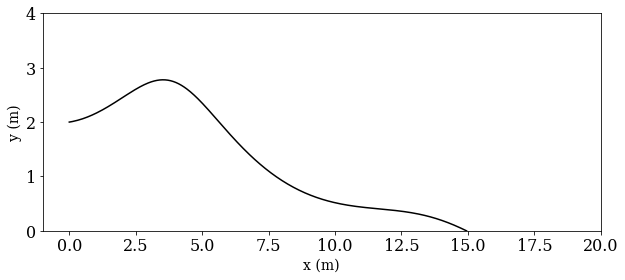

In [12]:
plt.figure(1)
plt.figure(figsize=(10, 4))
plt.ylim(0,4)
plt.xlim(-1,20)
plt.xlabel('x (m)', fontsize = 14)
plt.ylabel('y (m)', fontsize = 14)
plt.plot(u_set_trimmed[index_maxi][:,2], u_set_trimmed[index_maxi][:,3], 'k-')

---

###### The cell below loads the style of the notebook.

In [1]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())

In [14]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
